# Spike centered plot for Wang Buzsaki neuron model

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

from neuron import h
h.load_file("stdrun.hoc")
sys.path.insert(1, "../utils/")
import WB, Stimuli

In [3]:
sim_duration = 250000

ex_interval = 5
ex_weight = 0.00003

in_interval = 15
in_weight = 0.00005

ex_times = Stimuli.poisson_process_duration(5, sim_duration)
in_times = Stimuli.poisson_process_duration(15, sim_duration)

ex_stim = Stimuli.PoissonStim(
    name='ex',
    stim_id='ex',
    interval=ex_interval,
    rev_potential=0,
    weight=ex_weight,
    tau=2,
    seed='na',
    stim_times=ex_times
)


in_stim = Stimuli.PoissonStim(
    name='in',
    stim_id='in',
    interval=in_interval,
    rev_potential=-80,
    weight=in_weight,
    tau=6,
    seed='na',
    stim_times=in_times
)

wb = WB.WB()
wb.add_custom_stimulus(ex_stim)
wb.add_custom_stimulus(in_stim)
wb.run_simulation(sim_duration)

## action potential variance

In [6]:
def get_spike_windows(df, spikes, prespike_window=100, postspike_window=100):
    spike_windows = []
    for spike in spikes[10:-10]:
        start = int((spike-prespike_window)*40)
        stop = int((spike+postspike_window)*40)
        spike_windows.append((df[start:stop, :]))
    spike_windows = np.stack(spike_windows)
    return spike_windows

df = np.array([wb._v, wb._m_kdr, wb._h_naf]).T
spikes = list(wb.spike_times)
spike_windows = get_spike_windows( df, spikes)
print(spike_windows.shape)

(6252, 8000, 3)


In [9]:
# normalize
def normalize_vec(vec, axis=1):
    vec = vec - np.min(vec)
    vec = vec / np.max(vec)
    return vec

def normalize_df(spike_windows):
    return np.array(
        [normalize_vec(spike_windows[:,:,0]),
        normalize_vec(spike_windows[:,:,1]),
        normalize_vec(spike_windows[:,:,2])]
    )


spike_windows_norm = normalize_df(spike_windows)
spike_windows_norm.shape

(3, 6252, 8000)

In [10]:
spike_windows_vars = np.var(spike_windows_norm, axis = (0,1))

In [13]:
def state_variable_vars(spike_windows_norm):
    v_vars = np.var(spike_windows_norm[0,:], axis=(0))
    m_vars = np.var(spike_windows_norm[1,:], axis=(0))
    h_vars = np.var(spike_windows_norm[2,:], axis=(0))
    return v_vars, m_vars, h_vars
v_vars, m_vars, h_vars = state_variable_vars(spike_windows_norm)

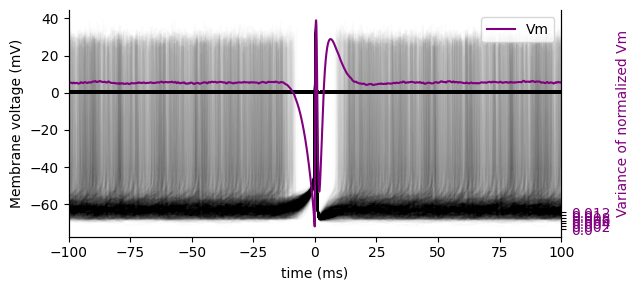

In [14]:
def spike_center_plot(spike_windows, v_vars, prespike_window=100, postspike_window=100, savefile=None):
    fig, ax = plt.subplots(figsize=(6.5,3))
    
    _t = np.arange(0, prespike_window+postspike_window, 1/40)
    
    num_traces = min(1000, spike_windows.shape[0])

    for i in range(num_traces):
        ax.plot(_t-prespike_window, spike_windows[i,:], c='black', alpha=0.01)

    ax2=ax.twinx()
    ax2.plot(_t-prespike_window, v_vars, c='purple')

    ax.set_ylabel('Membrane voltage (mV)')
    ax2.set_ylabel('Variance of normalized Vm', color='purple')
    ax2_yticks=np.arange(0,140,20)/10000
    ax2.set_yticks(ax2_yticks)
    ax2.set_yticklabels(ax2_yticks, color='purple')
    ax.set_xlabel('time (ms)')
    ax.set_xlim(0-prespike_window, postspike_window)
    
    ax2.legend(['Vm'])
    
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    plt.tight_layout()
    
    if savefile:
        plt.savefig(savefile+'.png', format='png', dpi=600)
        plt.savefig(savefile+'.svg', format='svg')
        
    plt.show()
    
spike_center_plot(spike_windows, spike_windows_vars)

In [ ]:
spike_windows_vars